In [21]:
import cv2
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

mask = cv2.imread('figure4-assignment3.jpg')     
image1 = cv2.imread('figure2-assignment3.jpg')             
image2 = cv2.imread('figure3-assignment3.jpg')

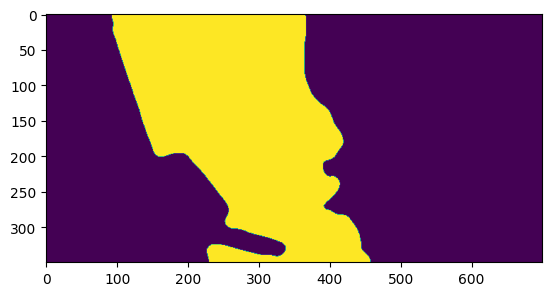

In [22]:
mask = cv2.medianBlur(mask, 11)                                           # blurring mask to remove artifacts
gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)                        # converting mask to grayscale
ret, gray_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)    # computing threshold for grayscale mask with threshold binary  

plt.imshow(gray_mask)
plt.show()                                           

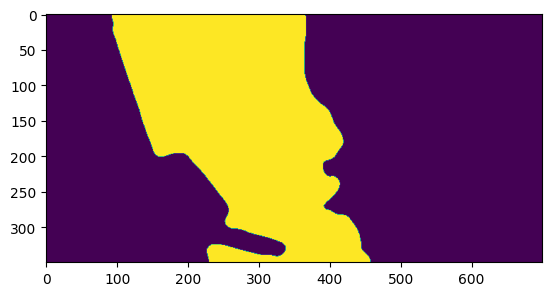

In [23]:
contours, _ = cv2.findContours(gray_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # finding contours for smoother mask outline
cv2.drawContours(mask, contours, -1, (255, 255, 255), 5)                          # drawing contours onto mask
mask[mask == 255] = 1                                                             # updating mask to be between 0..1 instead of 0..255

plt.imshow(gray_mask)
plt.show()    

In [24]:
def buildGaussianPyramid(src, maxVals):   # function to build gaussian pyramid
    layer = src.copy().astype('float32')
    g_pyr = [layer]
    for i in range(maxVals - 1):
        layer = cv2.pyrDown(layer)
        g_pyr.append(layer)
    return g_pyr

def buildLaplacianPyramid(g_Pyr):         # function to build laplacian pyramid
    lap_Pyr = []
    
    levels = len(g_Pyr)
    for i in range(levels-1):
        size = (g_Pyr[i].shape[1], g_Pyr[i].shape[0])
        layer = g_Pyr[i] - cv2.pyrUp(g_Pyr[i+1], dstsize=size)
        lap_Pyr.append(layer)

    lap_Pyr.append(g_Pyr[levels-1])
    return lap_Pyr

maxVals = 10       # setting max pyramid value for better composition

gaussianPyramidMask = buildGaussianPyramid(mask, maxVals)        # building gaussian pyramid for mask
print(f'nlevels of gaussianPyramidMask: {len(gaussianPyramidMask)}')

g_Pyr1 = buildGaussianPyramid(image1, maxVals)                   # building gaussian pyramid for image1
laplacianPyramidImage1 = buildLaplacianPyramid(g_Pyr1)           # building laplacian pyramid for image1
print(f'nlevels of laplacianPyramidImage1: {len(laplacianPyramidImage1)}')

g_Pyr2 = buildGaussianPyramid(image2, maxVals)                   # building gaussian pyramid for image2
laplacianPyramidImage2 = buildLaplacianPyramid(g_Pyr2)           # building laplacian pyramid for image2
print(f'nlevels of laplacianPyramidImage1: {len(laplacianPyramidImage2)}')

nlevels of gaussianPyramidMask: 10
nlevels of laplacianPyramidImage1: 10
nlevels of laplacianPyramidImage1: 10


shape of 0th layer: (350, 700, 3)


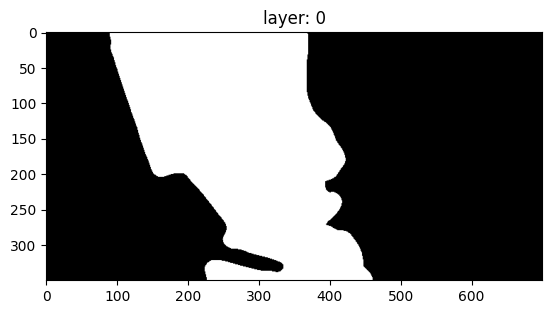

shape of 1th layer: (175, 350, 3)


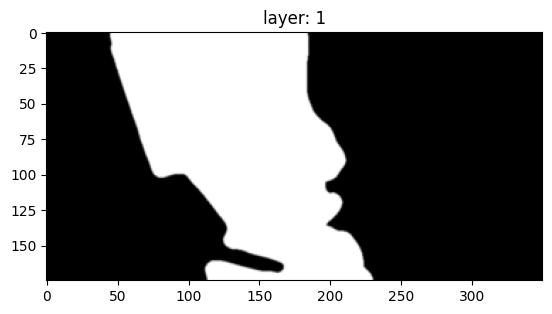

shape of 2th layer: (88, 175, 3)


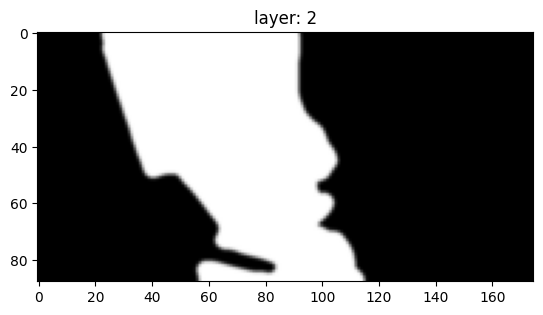

shape of 3th layer: (44, 88, 3)


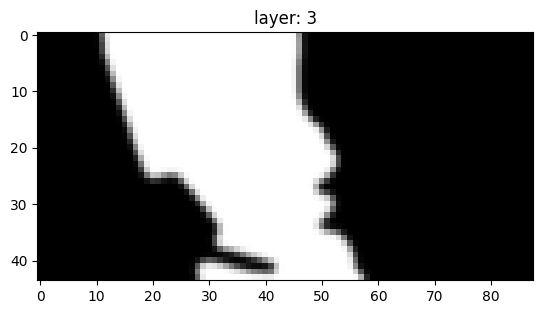

shape of 4th layer: (22, 44, 3)


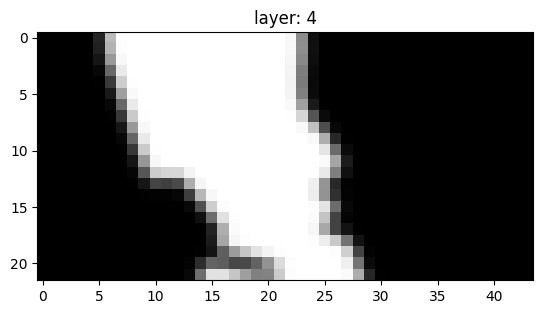

shape of 5th layer: (11, 22, 3)


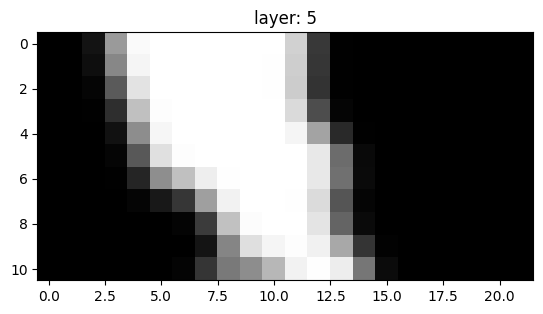

shape of 6th layer: (6, 11, 3)


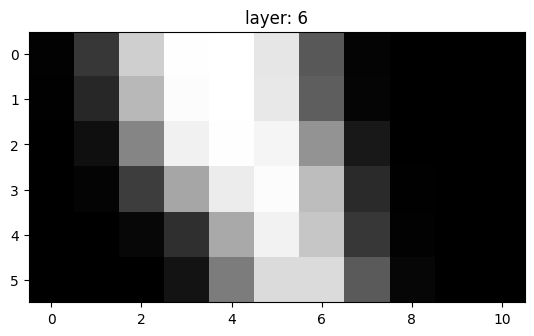

shape of 7th layer: (3, 6, 3)


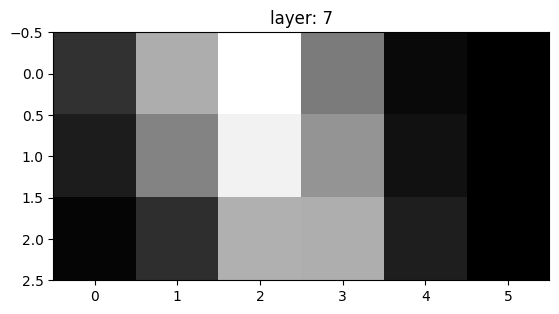

shape of 8th layer: (2, 3, 3)


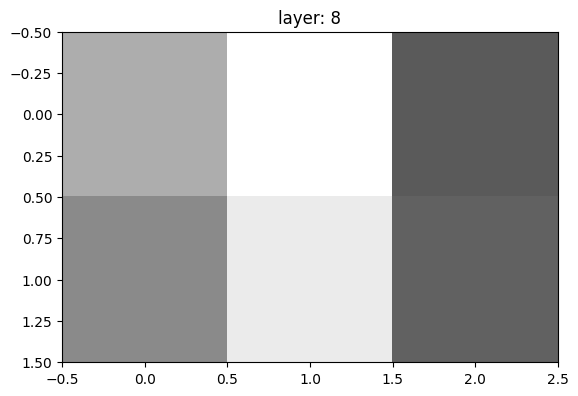

shape of 9th layer: (1, 2, 3)


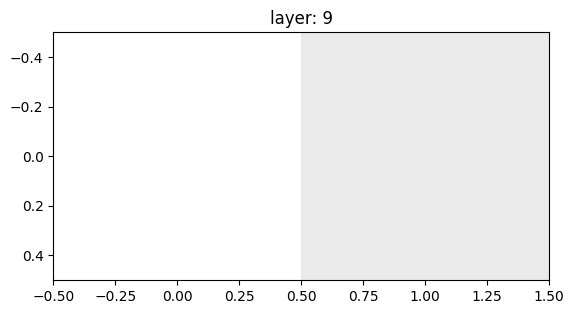

In [25]:
for i in range(maxVals):           #visualizing laplacian pyramid of mask
    layer = gaussianPyramidMask[i]
    
    print('shape of {}th layer: {}'.format(i, layer.shape))

    scale_factor = 255.0/np.max(layer)
    layer = cv2.convertScaleAbs(layer, alpha=scale_factor)
    layer = cv2.cvtColor(layer, cv2.COLOR_BGR2RGB)
    
    plt.title('layer: '+str(i))
    plt.imshow(layer)
    plt.show()

lap_pyr.shape: (350, 700, 3)


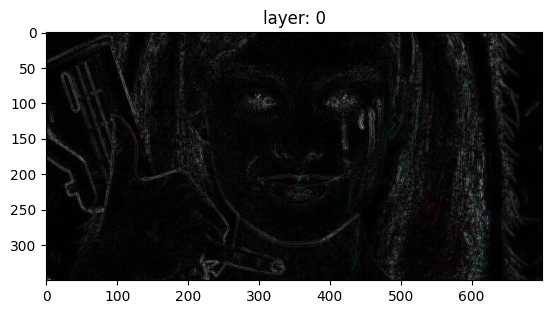

lap_pyr.shape: (175, 350, 3)


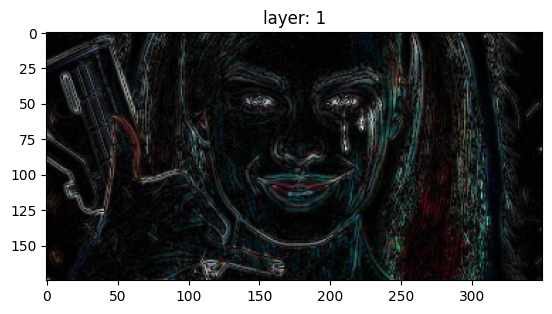

lap_pyr.shape: (88, 175, 3)


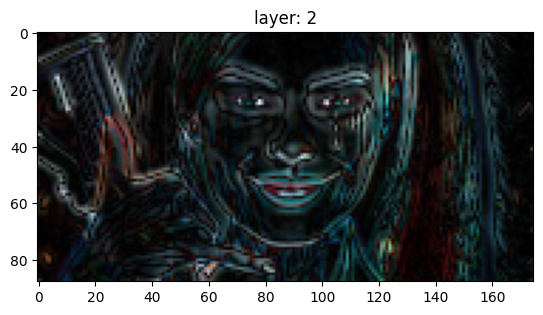

lap_pyr.shape: (44, 88, 3)


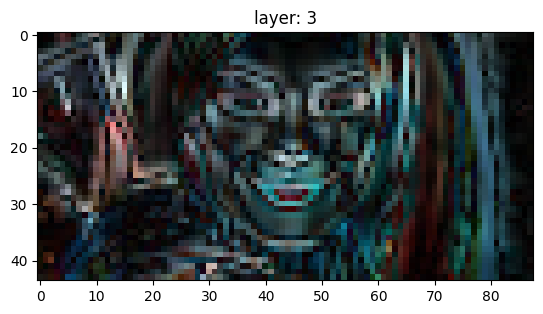

lap_pyr.shape: (22, 44, 3)


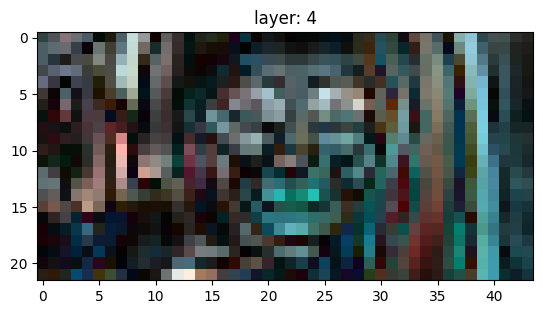

lap_pyr.shape: (11, 22, 3)


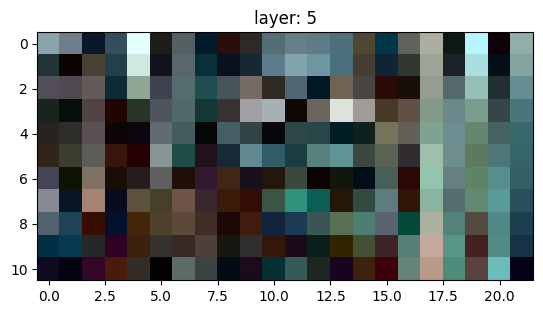

lap_pyr.shape: (6, 11, 3)


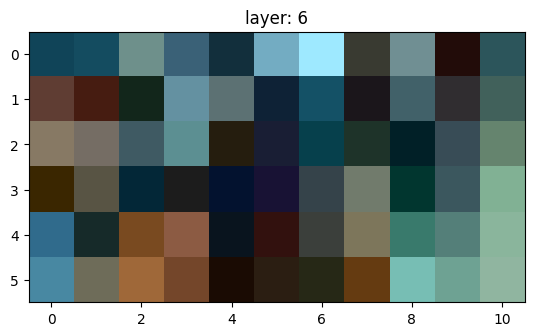

lap_pyr.shape: (3, 6, 3)


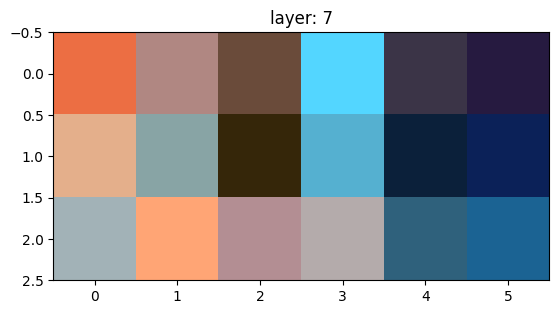

lap_pyr.shape: (2, 3, 3)


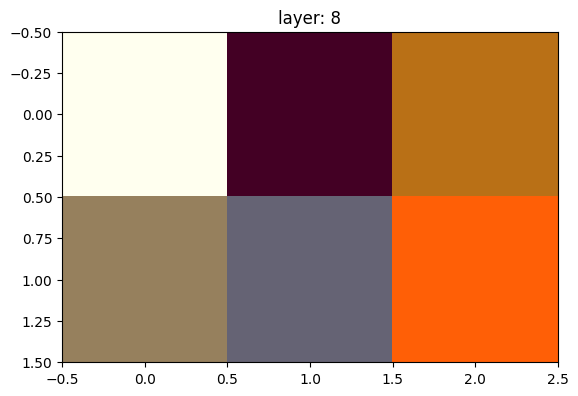

lap_pyr.shape: (1, 2, 3)


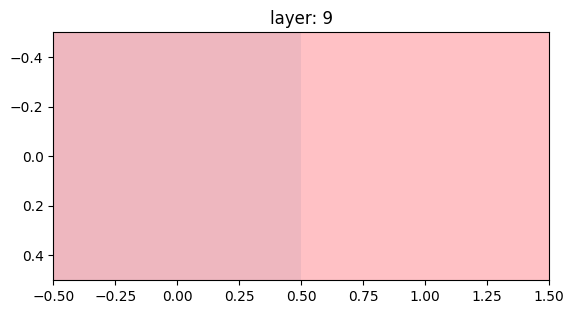

In [26]:
for i in range(maxVals):               #visualizing laplacian pyramid of image 1
    layer = laplacianPyramidImage1[i]
    plt.title('layer: '+str(i))
    print('lap_pyr.shape:', layer.shape)
    
    scale_factor = 255.0/np.max(layer)
    layer = cv2.convertScaleAbs(layer, alpha=scale_factor)
    layer = cv2.cvtColor(layer, cv2.COLOR_BGR2RGB)
    plt.imshow(layer)
    plt.show()

lap_pyr.shape: (350, 700, 3)


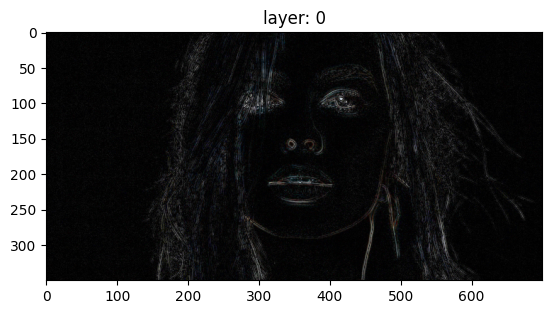

lap_pyr.shape: (175, 350, 3)


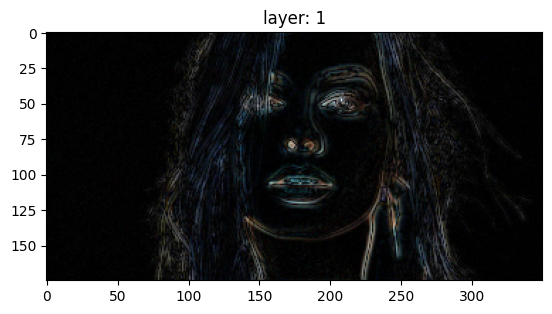

lap_pyr.shape: (88, 175, 3)


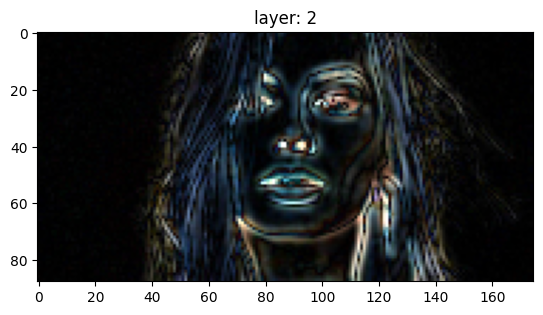

lap_pyr.shape: (44, 88, 3)


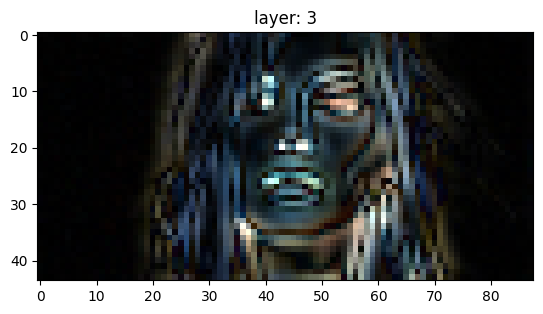

lap_pyr.shape: (22, 44, 3)


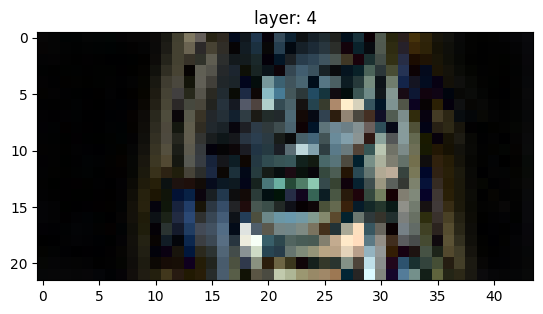

lap_pyr.shape: (11, 22, 3)


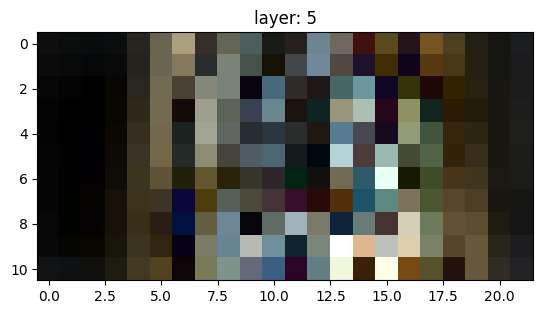

lap_pyr.shape: (6, 11, 3)


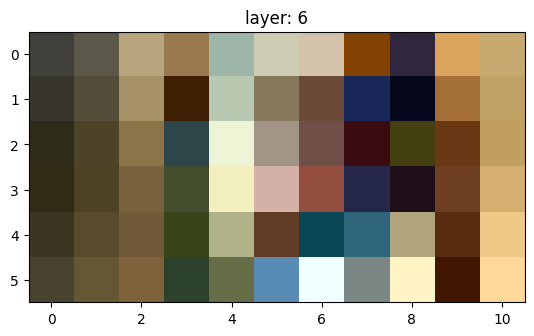

lap_pyr.shape: (3, 6, 3)


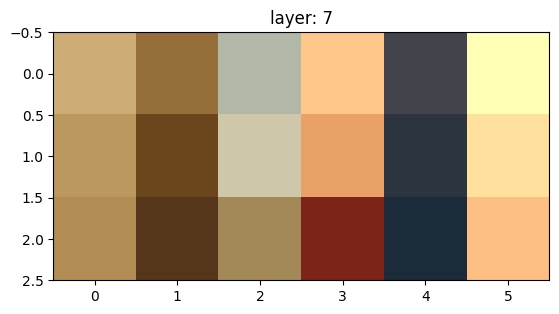

lap_pyr.shape: (2, 3, 3)


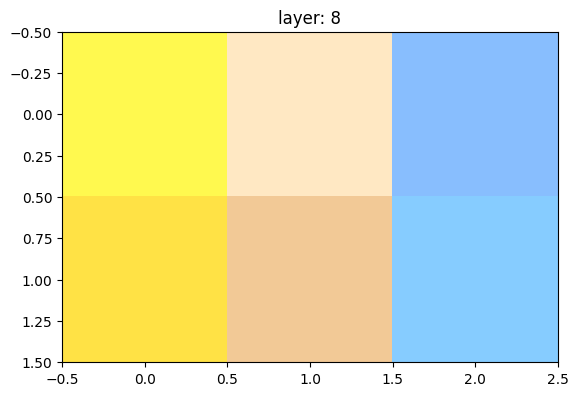

lap_pyr.shape: (1, 2, 3)


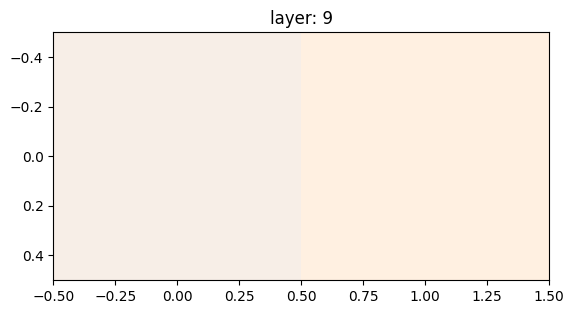

In [27]:
for i in range(maxVals):               #visualizing laplacian pyramid of image 2
    layer = laplacianPyramidImage2[i]
    plt.title('layer: '+str(i))
    print('lap_pyr.shape:', layer.shape)
    
    scale_factor = 255.0/np.max(layer)
    layer = cv2.convertScaleAbs(layer, alpha=scale_factor)
    layer = cv2.cvtColor(layer, cv2.COLOR_BGR2RGB)
    plt.imshow(layer)
    plt.show()

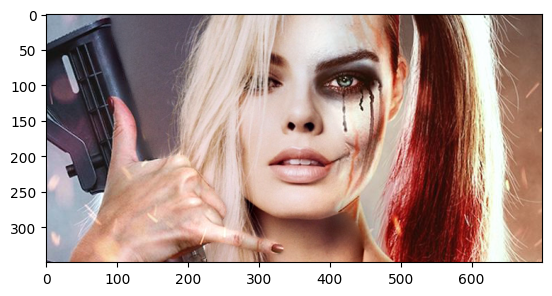

In [28]:
laplacianPyramidComposite = []               # building laplacian pyramid for composite image
for i in range(len(laplacianPyramidImage2)):
    laplacianPyramidComposite.append(
        (gaussianPyramidMask[i] * laplacianPyramidImage2[i]) + ((1 - gaussianPyramidMask[i]) * laplacianPyramidImage1[i]) 
    )    # image compositing formula

def reconstruct(low_res, high_res):
    upsampled_image = cv2.pyrUp(low_res, dstsize=(high_res.shape[1], high_res.shape[0])) # upsample lower resolution image to size of higher resolution image
    combined_image = upsampled_image + high_res      # add higher resolution image to upsampled image to restore details
    combined_image = np.clip(combined_image, 0, 255) # Ensure all pixel values are within 8-bit range [0, 255]
    return combined_image

compositeImage = np.uint8(              # to reconstruct composite image
    reduce(
        reconstruct,                    # the reconstruct function to apply iteratively
        laplacianPyramidComposite[::-1] # reversed laplacian pyramid for bottom-up reconstruction
    )
)

scale_factor = 255.0 / np.max(compositeImage)   # scale factor to normalize image pixel values to [0, 255]
compositeImage = cv2.convertScaleAbs(compositeImage, alpha = scale_factor) # normalize pixel intensities using scale factor
compositeImageRGB = cv2.cvtColor(compositeImage, cv2.COLOR_BGR2RGB) 

plt.figure()
plt.imshow(compositeImageRGB)
plt.show()